In [4]:

from model.model import EncoderModelWrapper
from model.model import EncoderCentroidLarger

modelPath = "model.pth"
model = EncoderModelWrapper(modelPath, EncoderCentroidLarger(), "cuda:0", False)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from handle_input import bboxes_to_model_input, positions_to_model_input, get_embedding

object1_points = []
object2_points = []
object3_points = []

# Object starting points
object1_points.append(np.array([0, 20]))
object2_points.append(np.array([-20, -20]))
object3_points.append(np.array([20, 20]))

# Move objects around.
# Object 1 and 2 are similar, object 3 is different.
for i in range(20):
    noise = np.random.randn(2) * 1
    noise2 = np.random.randn(2) * 1
    direction = np.array([np.cos(i*np.pi/50), np.sin(i*np.pi/50)])
    object1_points.append(object1_points[-1] + direction*5 + noise)
    object2_points.append(object2_points[-1] + direction*5 + noise2)
    object3_points.append(object3_points[-1] + noise + np.array([0, 5]))

# Convert points to bounding boxes (assuming fixed width/height)
bbox_width = 5
bbox_height = 5

# Typically, the data would start out as bounding boxes.
# We made this function to pretend we always had bounding boxes to start with.
# e.g. bboxes -> centroids -> embeddings
def points_to_bboxes(points, width, height):
    """Convert (x,y) points to bounding boxes [x1, y1, x2, y2]"""
    bboxes = []
    for point in points:
        if isinstance(point, np.ndarray):
            x, y = point[0], point[1]
        else:
            x, y = point
        x1 = x - width // 2
        y1 = y - height // 2
        x2 = x + width // 2
        y2 = y + height // 2
        bboxes.append([x1, y1, x2, y2])
    return bboxes

# Convert points to bounding boxes
object1_bboxes = points_to_bboxes(object1_points, bbox_width, bbox_height)
object2_bboxes = points_to_bboxes(object2_points, bbox_width, bbox_height)
object3_bboxes = points_to_bboxes(object3_points, bbox_width, bbox_height)


# Prepare data for model
# Below is the format we use for the model. We could even track multiple objects at once, 
# for example boxes_query = [object1_bboxes, object2_bboxes]
# We're just doing one object per embedding for now.
boxes_query = [object1_bboxes]
boxes_target = [object2_bboxes]
boxes_target_3 = [object3_bboxes]

# Convert to normalized model input and get embeddings
box_query_model_input = bboxes_to_model_input(boxes_query)
box_target_model_input = bboxes_to_model_input(boxes_target)
box_target_model_input_3 = bboxes_to_model_input(boxes_target_3)

# Get embeddings
box_query_embedding = get_embedding(model, box_query_model_input)
box_target_embedding = get_embedding(model, box_target_model_input)
box_target_embedding_3 = get_embedding(model, box_target_model_input_3)

# Compute similarity between embeddings
embedding_similarity = torch.nn.functional.cosine_similarity(box_query_embedding, box_target_embedding, dim=1)
embedding_similarity_3 = torch.nn.functional.cosine_similarity(box_query_embedding, box_target_embedding_3, dim=1)
print(f"Embedding similarity (object 1 and 2): {embedding_similarity}")
print(f"Embedding similarity (object 1 and 3): {embedding_similarity_3}")


Embedding similarity (object 1 and 2): tensor([0.7398], device='cuda:0')
Embedding similarity (object 1 and 3): tensor([0.0477], device='cuda:0')


Visualization complete!


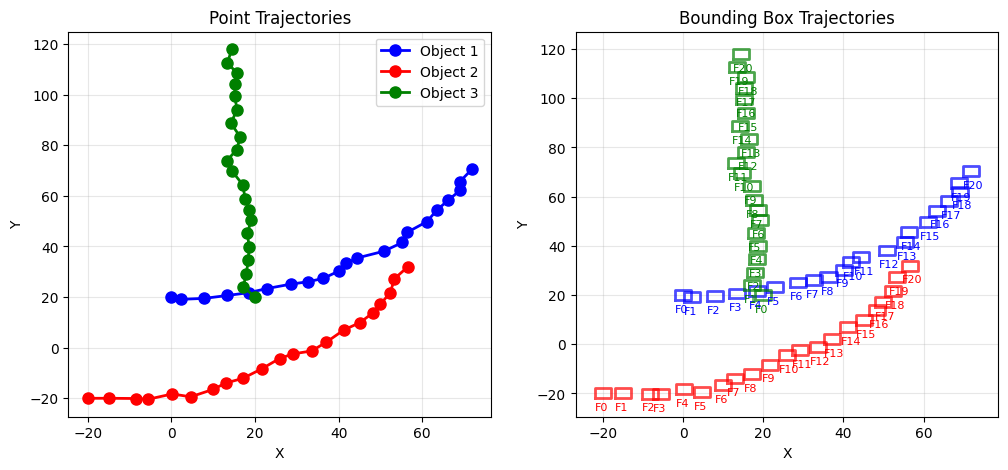

In [75]:
# Simple visualization without complex matplotlib features
import matplotlib.pyplot as plt

# Create a simple plot
plt.figure(figsize=(12, 5))

# Plot 1: Points trajectory
plt.subplot(1, 2, 1)
plt.title('Point Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)

# Plot object 1 points
x1_coords = [p[0] for p in object1_points]
y1_coords = [p[1] for p in object1_points]
plt.plot(x1_coords, y1_coords, 'bo-', label='Object 1', linewidth=2, markersize=8)

# Plot object 2 points
x2_coords = [p[0] for p in object2_points]
y2_coords = [p[1] for p in object2_points]
plt.plot(x2_coords, y2_coords, 'ro-', label='Object 2', linewidth=2, markersize=8)

# Plot object 3 points
x3_coords = [p[0] for p in object3_points]
y3_coords = [p[1] for p in object3_points]
plt.plot(x3_coords, y3_coords, 'go-', label='Object 3', linewidth=2, markersize=8)

plt.legend()

# Plot 2: Bounding box trajectories
plt.subplot(1, 2, 2)
plt.title('Bounding Box Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)

# Plot object 1 bounding boxes
for i, bbox in enumerate(object1_bboxes):
    x1, y1, x2, y2 = bbox
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-', linewidth=2, alpha=0.7)
    plt.text(x1, y1-5, f'F{i}', fontsize=8, color='blue')

# Plot object 2 bounding boxes
for i, bbox in enumerate(object2_bboxes):
    x1, y1, x2, y2 = bbox
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2, alpha=0.7)
    plt.text(x1, y1-5, f'F{i}', fontsize=8, color='red')

# Plot object 3 bounding boxes
for i, bbox in enumerate(object3_bboxes):
    x1, y1, x2, y2 = bbox
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-', linewidth=2, alpha=0.7)
    plt.text(x1, y1-5, f'F{i}', fontsize=8, color='green')

print("Visualization complete!")


# Rotation Robustness
* To make the embeddings more robust, we can average them across various rotation perturbations.
* You should notice that the similarity between object1 and object2 trajectories should be higher here.
* While similarity between object1 and object3 trajectories should still be low here.


In [77]:
# Rotation averaging - fix the data format
from utils import rotate_clip_centroids
from handle_input import centroids2model_input

# Convert object2_points to proper format: (num_objects, num_frames, 2)
object2_points_array = np.array(object2_points)  # Shape: (num_frames, 2)
object2_points_3d = object2_points_array.reshape(1, -1, 2)  # Shape: (1, num_frames, 2)
print(object2_points_3d.shape)

# Create rotated versions
q_inputs = [centroids2model_input(object2_points_3d)]
for _ in range(100):
    rotated_points = rotate_clip_centroids(object2_points_3d)
    q_inputs.append(centroids2model_input(rotated_points))

# Stack inputs and get embeddings
stacked_inputs = torch.stack(q_inputs)
embeds = model.net(stacked_inputs.to(model.device))
embed_avg = torch.mean(embeds, dim=0)

print(f"Rotation averaged embedding shape: {embed_avg.shape}")

similarity = torch.nn.functional.cosine_similarity(box_target_embedding, embed_avg, dim=1)
print(f"Similarity: {similarity}")

similarity_3 = torch.nn.functional.cosine_similarity(box_target_embedding_3, embed_avg, dim=1)
print(f"Similarity: {similarity_3}")


(1, 21, 2)
Rotation averaged embedding shape: torch.Size([512])
Similarity: tensor([0.9188], device='cuda:0', grad_fn=<SumBackward1>)
Similarity: tensor([0.0186], device='cuda:0', grad_fn=<SumBackward1>)
